In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader

# IndoBERT
from transformers import AutoTokenizer, AutoModel

# Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


Using device: cpu


In [ ]:
NORMALIZATION_DICT = {
    'gak': 'tidak','ga': 'tidak','gk': 'tidak',
    'ngga': 'tidak','nggak': 'tidak',
    'yg': 'yang','dgn': 'dengan','utk': 'untuk',
    'pd': 'pada','krn': 'karena',
    'tdk': 'tidak','sdh': 'sudah','blm': 'belum',
    'jg': 'juga','jd': 'jadi','dll': 'dan lain lain'
}

def clean_text(text):
    if pd.isna(text): return ""
    text = re.sub(r"http\S+|www\S+|https\S+", "", str(text))
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_pipeline(text):
    text = clean_text(text).lower()
    return " ".join([NORMALIZATION_DICT.get(w, w) for w in text.split()])


Jumlah Data Asli: 2924
label
0    2523
2     332
1      69
Name: count, dtype: int64


In [ ]:
df = pd.read_csv("data_prelabeled_full.csv")

df = df.dropna(subset=['aspect','context','polaritas'])
df['aspect_clean'] = df['aspect'].apply(preprocess_pipeline)
df['context_clean'] = df['context'].apply(preprocess_pipeline)

df['polaritas'] = df['polaritas'].str.lower().str.strip()
label_map = {'negatif':0,'netral':1,'positif':2}
df['label'] = df['polaritas'].map(label_map)

df = df.dropna(subset=['label'])
df['text'] = (df['aspect_clean'] + " " + df['context_clean']).str.strip()
df = df[df['text'] != ""]

print("Jumlah Data:", len(df))
df['label'].value_counts()


Train: 2339
Test : 585


In [ ]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

print("TRAIN:", len(train_df))
print("TEST :", len(test_df))
train_df['label'].value_counts(), test_df['label'].value_counts()


Kelas 0 memiliki 2848 sampel sebelum balancing
Kelas 2 memiliki 372 sampel sebelum balancing
Kelas 1 memiliki 78 sampel sebelum balancing

Distribusi Data Train Final (Target Sama):
label
0    2018
2    2018
1    2018
Name: count, dtype: int64


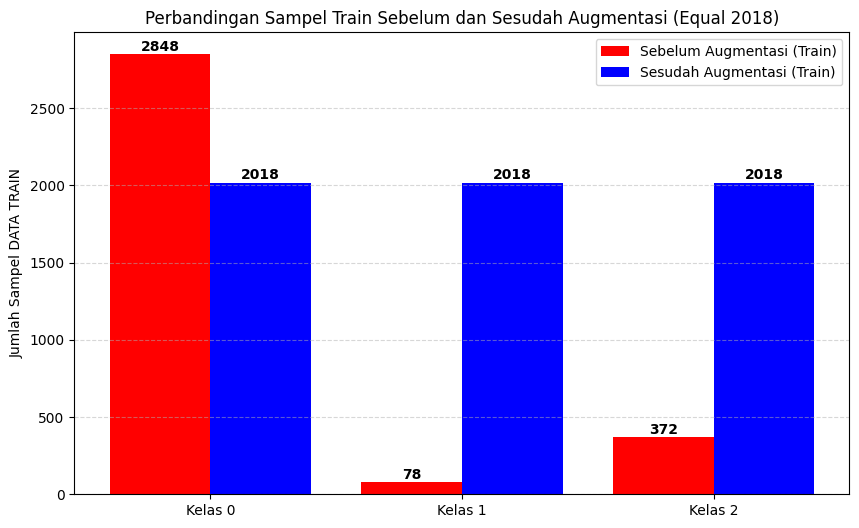

In [ ]:
MODEL_NAME = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
bert_model.eval()


In [ ]:
def get_bert_embeddings(texts, batch_size=16):
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
            batch = texts[i:i+batch_size]

            enc = tokenizer(batch, padding=True, truncation=True,
                            max_length=128, return_tensors="pt")

            outputs = bert_model(
                enc["input_ids"].to(device),
                attention_mask=enc["attention_mask"].to(device)
            )

            last_hidden = outputs.last_hidden_state
            mask = enc["attention_mask"].unsqueeze(-1).expand(last_hidden.size()).float()

            mean_emb = (last_hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
            embeddings.append(mean_emb.cpu().numpy())
    return np.vstack(embeddings)


In [ ]:
X_train = get_bert_embeddings(train_df['text'].tolist())
X_test = get_bert_embeddings(test_df['text'].tolist())

X_train.shape, X_test.shape


Embedding: 100%|██████████| 37/37 [00:25<00:00,  1.47it/s]

(6054, 768) (585, 768)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

pca = PCA(n_components=150, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape


Training selesai!


Accuracy: 0.8205128205128205
              precision    recall  f1-score   support

     negatif       0.93      0.87      0.90       505
      netral       0.18      0.43      0.26        14
     positif       0.44      0.55      0.49        66

    accuracy                           0.82       585
   macro avg       0.52      0.61      0.55       585
weighted avg       0.86      0.82      0.84       585



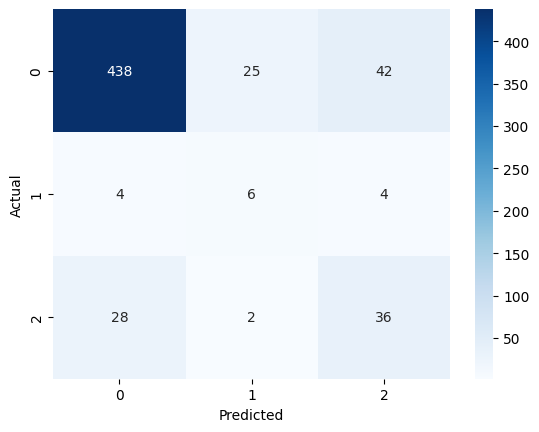

In [ ]:
clf = LogisticRegression(max_iter=3000, n_jobs=-1)
clf.fit(X_train_pca, train_df['label'])

print("Training selesai!")


In [ ]:
y_pred = clf.predict(X_test_pca)

print("Accuracy:", accuracy_score(test_df['label'], y_pred))
print(classification_report(test_df['label'], y_pred, target_names=['negatif','netral','positif']))

sns.heatmap(confusion_matrix(test_df['label'], y_pred),
            annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix - IndoBERT + Logistic Regression (No Augment)")
plt.show()
